<a href="https://colab.research.google.com/github/arny617/MLNanodegree/blob/master/AmazonReviewsSentimentAnalysis_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
ROOT = "/content/gdrive/My Drive/Colab Notebooks/"
os.chdir(ROOT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import bz2
from collections import Counter
import re
import nltk
import numpy as np
nltk.download('punkt')
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
train = bz2.BZ2File('./SentimentAnalysis/train.ft.txt.bz2')
test = bz2.BZ2File('./SentimentAnalysis/test.ft.txt.bz2')

In [6]:
train = train.readlines()
test = test.readlines()

In [7]:
print("No. of training reivews: " + str(len(train)))
print("No. of test reviews: " + str(len(test)))

No. of training reivews: 3600000
No. of test reviews: 400000


In [8]:
num_train = 200000
num_test = 20000

train_data = [x.decode('utf-8') for x in train[:num_train]]
test_data = [x.decode('utf-8') for x in test[:num_test]]

In [ ]:
#train_data[:-1]

In [9]:
### Positive labels: 1, Negative: 0
trainLabels = [1 if x.split(' ')[0] == '__label__1' else 0 for x in train_data]
trainText = [x.split(' ', 1)[1][:-1].lower() for x in train_data]

In [10]:
### Positive labels: 1, Negative: 0
testLabels = [1 if x.split(' ')[0] == '__label__1' else 0 for x in test_data]
testText = [x.split(' ', 1)[1][:-1].lower() for x in test_data]

In [11]:
nltk.download('stopwords')
from nltk.corpus import stopwords as sw
stopwords = sw.words("english")
from tqdm import tqdm_notebook

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def cleanText(text):
  for i in tqdm_notebook(range(len(text))):
      elem = [x for x in simple_preprocess(text[i],deacc = True) if x not in stopwords]
      text[i] = elem
  return text

In [13]:
trainText = cleanText(trainText)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
#trainText

In [14]:
testText = cleanText(testText)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


### Fast AI

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
len(trainText)

200000

In [17]:
df_train = pd.DataFrame(list(zip(trainLabels, trainText)),columns = ['Label','Text'])
df_test = pd.DataFrame(list(zip(testLabels, testText)),columns = ['Label','Text'])

In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai import *
from fastai.text import *
from scipy.spatial.distance import cosine as dist

In [20]:
torch.cuda.set_device(0)

In [21]:
from fastai.text import *

In [22]:
data = (TextList.from_df(df_train, cols=['Text'])
                .split_by_rand_pct(0.2,seed=42)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"' game ' , ' music ' , ' played ' , ' game ' , ' chrono ' , ' cross ' , ' games ' , ' ever ' , ' played ' , ' best ' , ' music ' , ' backs ' , ' away ' , ' crude ' , ' keyboarding ' , ' takes ' , ' fresher ' , ' step"
1,"' session ' , ' backed ' , ' june ' , ' christy ' , ' regular ' , ' orchestra ' , ' shows ' , ' bad ' , ' singer ' , ' page ' , ' comparison ' , ' gifted ' , ' miss ' , ' christy ' , ' miss ' , ' page ' , ' syncopation ' , ' rhythm"
2,"' , ' everything ' , ' billed ' , ' picked ' , ' classic ' , ' read ' , ' summer ' , ' one ' , ' better ' , ' choices ' , ' made ' , ' annual ' , ' quest ' , ' although ' , ' must ' , ' admit ' , ' getting ' , ' lost ' ,"
3,"paper ' , ' fed ' , ' prints ' , ' fine ' , ' getting ' , ' paper ' , ' feed ' , ' issue ' , ' frustrating ' , ' next ' , ' time ' , ' buying ' , ' different ' , ' brand ' ] xxbos [ ' work ' , ' item ' , ' number ' , '"
4,"know ' , ' someone ' , ' dealing ' , ' situation ' , ' like ' , ' talking ' , ' good ' , ' friend ' ] xxbos [ ' quick ' , ' delivery ' , ' great ' , ' service ' , ' quick ' , ' delivery ' , ' ordered ' , ' book ' , ' several ' , '"


In [23]:
### Fit bitcoin wikitext model with domain specific data
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.4)

In [24]:
# select the appropriate learning rate
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


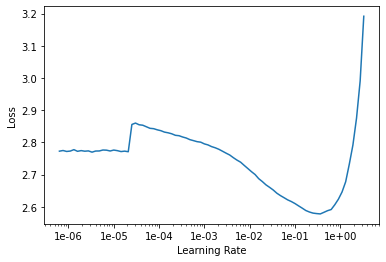

In [25]:
learn.recorder.plot()

In [27]:
bs = 48
lr = 1e-3
lr *= bs/48

In [28]:
learn.fit_one_cycle(2, lr*10, moms=(0.8,0.7))
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,1.904280,1.835334,0.762725,41:53
1,1.871520,1.796084,0.764543,41:59


In [29]:
learn.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.741887,1.726591,0.767768,48:30


In [30]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

#### Refit using Label column

In [31]:
test_datalist = TextList.from_df(df_test, cols='Text', vocab=data.vocab)
data_clas = (TextList.from_df(df_train, cols=['Text'], vocab=data.vocab)
             .split_by_rand_pct(0.2,seed=42)
             .label_from_df(cols= 'Label')
             .databunch(bs=48))

data_clas.show_batch()

text,target
"xxbos [ ' quieres ' , ' conocer ' , ' al ' , ' dios ' , ' verdadero ' , ' lee ' , ' la ' , ' biblia ' , ' deepak ' , ' chopra ' , ' habla ' , ' de ' , ' ese ' , ' dios ' , ' al ' , ' que ' , ' hay ' ,",1
"xxbos [ ' weapon ' , ' unloaded ' , ' worst ' , ' entry ' , ' lethal ' , ' weapon ' , ' series ' , ' first ' , ' always ' , ' best ' , ' lethal ' , ' weapon ' , ' suffers ' , ' much ' , ' comedy ' , ' uninteresting ' , ' story ' ,",1
"xxbos [ ' every ' , ' wonk ' , ' know ' , ' locked ' , ' cage ' , ' new ' , ' york ' , ' saw ' , ' heap ' , ' charlie ' , ' abrams ' , ' reports ' , ' abrams ' , ' un ' , ' urban ' , ' trouble ' , ' shooter ' ,",0
"xxbos [ ' break ' , ' easily ' , ' expected ' , ' great ' , ' addition ' , ' tools ' , ' collection ' , ' long ' , ' extension ' , ' bars ' , ' drive ' , ' useful ' , ' many ' , ' applications ' , ' tried ' , ' use ' , ' take ' ,",1
"xxbos [ ' poorly ' , ' made ' , ' first ' , ' pros ' , ' heavy ' , ' enough ' , ' suction ' , ' feet ' , ' prevent ' , ' slicer ' , ' moving ' , ' around ' , ' counter ' , ' simple ' , ' operate ' , ' cons ' , ' blade ' ,",1


In [32]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[Precision(average='micro')])

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')

learn_classifier.freeze()

In [33]:
# select the appropriate learning rate
learn_classifier.lr_find()

epoch,train_loss,valid_loss,precision,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


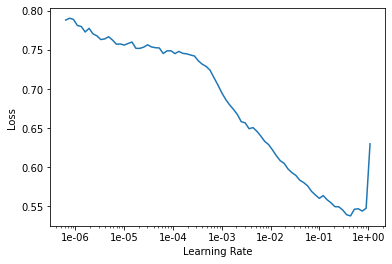

In [34]:
# we typically find the point where the slope is steepest
learn_classifier.recorder.plot()

In [35]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,precision,time
0,0.336295,0.287638,0.879375,09:34


In [36]:
# Tune a little more
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,precision,time
0,0.285960,0.238461,0.903850,12:19


In [37]:
#learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,precision,time
0,0.268948,0.240710,0.907175,12:05
1,0.269287,0.230864,0.908000,11:59


In [38]:
learn_classifier.show_results()

text,target,prediction
"xxbos [ ' excelente ' , ' disco ' , ' tienen ' , ' que ' , ' comprarlo ' , ' patricia ' , ' con ' , ' este ' , ' disco ' , ' se ' , ' xxunk ' , ' otros ' , ' ya ' , ' que ' , ' nos ' , ' xxunk ' , ' su ' ,",0,0
"xxbos [ ' saludos ' , ' otros ' , ' xxunk ' , ' veces ' , ' es ' , ' xxunk ' , ' que ' , ' el ' , ' texto ' , ' xxunk ' , ' por ' , ' los ' , ' xxunk ' , ' fue ' , ' xxunk ' , ' xxunk ' , ' por ' ,",1,0
"xxbos [ ' bastante ' , ' bueno ' , ' ok ' , ' la ' , ' xxunk ' , ' de ' , ' esta ' , ' novela ' , ' es ' , ' buena ' , ' trata ' , ' un ' , ' tema ' , ' poco ' , ' usual ' , ' el ' , ' xxunk ' ,",0,0
"xxbos [ ' unmasked ' , ' animalize ' , ' asylum ' , ' crazy ' , ' nights ' , ' pc ' , ' donde ' , ' xxunk ' , ' este ' , ' grandes ' , ' exitos ' , ' tiene ' , ' el ' , ' xxunk ' , ' del ' , ' xxunk ' , ' del ' ,",1,0
"xxbos [ ' suena ' , ' interesante ' , ' este ' , ' libro ' , ' hace ' , ' muchas ' , ' xxunk ' , ' decir ' , ' creo ' , ' que ' , ' todas ' , ' sean ' , ' xxunk ' , ' pero ' , ' si ' , ' al ' , ' menos ' ,",0,0


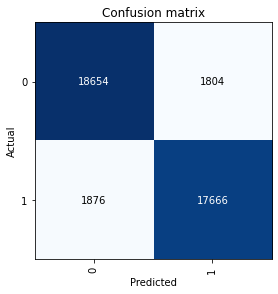

In [39]:
interp = ClassificationInterpretation.from_learner(learn_classifier)
interp.plot_confusion_matrix()

In [40]:
y_valid = interp.data.valid_ds.y.items
y_pred = interp.pred_class.numpy()

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_valid,
                            y_pred,
                            target_names= ['0', '1']))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     20458
           1       0.91      0.90      0.91     19542

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000

